In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import heapq
import math

# ==========================================
# 1. TẠO MẠNG LƯỚI & DỮ LIỆU
# ==========================================
width, height = 30, 30
G = nx.grid_2d_graph(width, height)

# Gán trọng số cạnh = 1.0 (như Table 1, dòng 9: W(p,q)) [cite: 227]
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = 1.0

pos = {node: node for node in G.nodes()}

# Hàm sinh dữ liệu giả lập
def get_nearby_nodes(center_node, radius, count):
    candidates = []
    for node in G.nodes():
        dist = abs(node[0] - center_node[0]) + abs(node[1] - center_node[1])
        if dist <= radius:
            candidates.append(node)
    return random.sample(candidates, min(len(candidates), count))

data_nodes = []
data_nodes.extend(get_nearby_nodes((5, 5), radius=4, count=50))
data_nodes.extend(get_nearby_nodes((25, 25), radius=4, count=40))
data_nodes.extend(get_nearby_nodes((15, 15), radius=3, count=20))
all_nodes = list(G.nodes())
noise_points = random.sample(all_nodes, 40)
data_nodes.extend(noise_points)
data_nodes = list(set(data_nodes))
n_samples = len(data_nodes)

print(f"Tổng số điểm dữ liệu: {n_samples}")

Tổng số điểm dữ liệu: 136


In [2]:
# ==========================================
# THUẬT TOÁN 1: LSPD (Table 1 trong bài báo) [cite: 226]
# ==========================================
def algorithm_1_LSPD(G, cp, eps, data_set_lookup):
    """
    Input: graph N, central vertex cp, radius eps
    Output: cp's eps-neighbors N_eps(cp)
    """
    # Khởi tạo CDCV (Current Distance to Central Vertex) [cite: 227]
    distances = {cp: 0}
    
    # cp is inserted into a newly initiated queue Q (Table 1, Line 1) [cite: 227]
    queue = [(0, cp)]
    
    n_eps = [] # Danh sách hàng xóm

    # while Q is not empty do (Table 1, Line 2) [cite: 227]
    while queue:
        # p is dequeued from Q (Table 1, Line 3)
        cdcv_p, p = heapq.heappop(queue)
        
        # Điều kiện dừng mở rộng (Table 1, Line 8 logic)
        if cdcv_p > eps:
            continue

        # if p is an event vertex... then add p to N_eps(cp) (Table 1, Line 4-6) [cite: 227]
        if p in data_set_lookup:
            n_eps.append(p)
        
        # for each vertex q adjacent to p do (Table 1, Line 7) [cite: 227]
        for q in G.neighbors(p):
            w_pq = G[p][q]['weight']
            new_dist = cdcv_p + w_pq
            
            # if CDCV(p) + W(p,q) <= eps (Table 1, Line 8) [cite: 227]
            if new_dist <= eps:
                # Cập nhật CDCV(q) (Table 1, Line 9)
                if new_dist < distances.get(q, float('inf')):
                    distances[q] = new_dist
                    # q is enqueued to Q (Table 1, Line 11) [cite: 227]
                    heapq.heappush(queue, (new_dist, q))
                    
    return n_eps

# ==========================================
# THUẬT TOÁN 2: GENERATING DENSITY ORDERING (Table 2) [cite: 259]
# ==========================================
def algorithm_2_density_ordering(G, data_points, eps):
    """
    Input: undirected planar graph N, radius eps
    Output: density ordering table (dạng list các dict), cache hàng xóm
    """
    data_set_lookup = set(data_points)
    
    # 1) initialize density ordering table (Table 2, Line 1) 
    # Chúng ta dùng list để giữ thứ tự, và set để kiểm tra tồn tại nhanh
    density_ordering_table = [] 
    in_table_set = set()
    
    # Cache để tránh tính lại LSPD nhiều lần (tối ưu thực tế)
    neighbors_cache = {} 
    density_cache = {}

    # Hàm phụ trợ tính mật độ
    def get_density_info(p):
        if p not in neighbors_cache:
            nbrs = algorithm_1_LSPD(G, p, eps, data_set_lookup)
            neighbors_cache[p] = nbrs
            density_cache[p] = len(nbrs)
        return density_cache[p], neighbors_cache[p]

    # for each point p do (Table 2, Line 2) 
    # Lưu ý: Bài báo ngụ ý duyệt qua các điểm chưa được xử lý
    for p in data_points:
        
        # if p is not in density ordering table then (Table 2, Line 3) 
        if p not in in_table_set:
            
            # p is inserted into Q (Table 2, Line 4) 
            # Q ở đây cần ưu tiên mật độ cao -> thấp. Dùng Max-Heap (lưu âm density)
            p_density, _ = get_density_info(p)
            Q = [(-p_density, p)] 
            in_Q_set = {p} # Set để kiểm tra nhanh ai đang trong Q
            
            # while Q is not empty do (Table 2, Line 6) 
            while Q:
                # the first point q is dequeued from Q (Table 2, Line 7) 
                neg_dens, q = heapq.heappop(Q)
                q_density = -neg_dens
                
                # write density... into table (Table 2, Line 7) 
                if q not in in_table_set:
                    density_ordering_table.append(q)
                    in_table_set.add(q)
                
                # for each point neighbor in N_eps(q) do (Table 2, Line 8) 
                _, q_neighbors = get_density_info(q)
                
                for neighbor in q_neighbors:
                    # if neighbor's density is unknown then calculate (Table 2, Line 9-10)
                    nb_density, _ = get_density_info(neighbor)
                    
                    # if neighbor is not in table nor in Q (Table 2, Line 12) 
                    if (neighbor not in in_table_set) and (neighbor not in in_Q_set):
                        # add neighbor into Q to make densities... from high to low (Table 2, Line 13)
                        heapq.heappush(Q, (-nb_density, neighbor))
                        in_Q_set.add(neighbor)
                        
    # Kết quả trả về là bảng đã sắp xếp theo cấu trúc "đồi" (hills) như mô tả trong Figure 5 [cite: 257]
    return density_ordering_table, neighbors_cache

# ==========================================
# THUẬT TOÁN 3: FORMING CLUSTERS (Table 3) [cite: 271]
# ==========================================
def algorithm_3_forming_clusters(density_ordering_table, neighbors_cache, min_pts):
    """
    Input: density ordering table, density threshold MinPts
    Output: density-based clusters (labels dict)
    """
    labels = {} # Lưu kết quả
    cluster_id = 0
    NOISE = -1
    
    # for each event point p in density ordering table do (Table 3, Line 1) [cite: 271]
    for p in density_ordering_table:
        
        # if p does not belong to any cluster or noises then (Table 3, Line 2) [cite: 271]
        if p in labels:
            continue
            
        p_neighbors = neighbors_cache[p]
        p_density = len(p_neighbors)
        
        # if the density of p is less than MinPts then mark p as noise (Table 3, Line 3-4) [cite: 271]
        if p_density < min_pts:
            labels[p] = NOISE
            
        # else (Table 3, Line 5) [cite: 271]
        else:
            # create a new cluster C containing p (Table 3, Line 6) [cite: 271]
            cluster_id += 1
            labels[p] = cluster_id
            
            # for each point q in cluster C do (Table 3, Line 8) [cite: 271]
            # (Dùng danh sách seeds để mô phỏng việc C mở rộng)
            seeds = [p] # p đã ở trong C, nhưng ta cần duyệt border của nó
            i = 0
            while i < len(seeds):
                q = seeds[i]
                q_neighbors = neighbors_cache[q] # Lấy từ cache
                q_density = len(q_neighbors)
                
                # if q is a core point then (Table 3, Line 9) [cite: 271]
                if q_density >= min_pts:
                    
                    # for each point s in q's border points do (Table 3, Line 10) [cite: 271]
                    # (Border points chính là các điểm trong N_eps(q))
                    for s in q_neighbors:
                        
                        # if s is not a member of cluster C (Table 3, Line 11) [cite: 271]
                        # Logic thực tế của DBSCAN:
                        # 1. Nếu s chưa có nhãn -> Gán vào C, thêm vào seeds để xét tiếp
                        # 2. Nếu s là NOISE -> Gán vào C (nhưng không thêm vào seeds - nó là biên)
                        
                        if s not in labels: # Chưa có nhãn
                            labels[s] = cluster_id
                            seeds.append(s) # add s to cluster C loop
                        elif labels[s] == NOISE: # Đã bị đánh dấu là Nhiễu
                            labels[s] = cluster_id # Cứu thành biên
                            # Không append s vào seeds (vì nó không phải core point hoặc đã xét)
                            
                i += 1
                
    return labels

# ==========================================
# CHẠY FULL QUY TRÌNH (MAIN)
# ==========================================
def run_ns_dbscan_paper_version(G, data_points, eps, min_pts):
    print("--- BẮT ĐẦU NS-DBSCAN (PAPER VERSION) ---")
    
    # BƯỚC 1 & 2: Tạo bảng sắp xếp mật độ (Algorithm 2 gọi Algorithm 1)
    # [cite: 162] "Step 1: Generating density ordering... included two substeps: obtaining eps-neighbors... and generating density ordering table"
    print("Step 1: Generating Density Ordering...")
    table, cache = algorithm_2_density_ordering(G, data_points, eps)
    
    print(f"   -> Đã sắp xếp {len(table)} điểm vào bảng.")
    
    # BƯỚC 3: Hình thành cụm (Algorithm 3)
    # [cite: 165] "Step 2: Forming clusters... clusters were formed by categorizing... points"
    print("Step 2: Forming Clusters...")
    labels = algorithm_3_forming_clusters(table, cache, min_pts)
    
    return labels

--- BẮT ĐẦU NS-DBSCAN (PAPER VERSION) ---
Step 1: Generating Density Ordering...
   -> Đã sắp xếp 136 điểm vào bảng.
Step 2: Forming Clusters...

KẾT QUẢ:
- Tổng số điểm: 136
- Điểm thuộc cụm: 100
- Điểm nhiễu (NOISE): 36


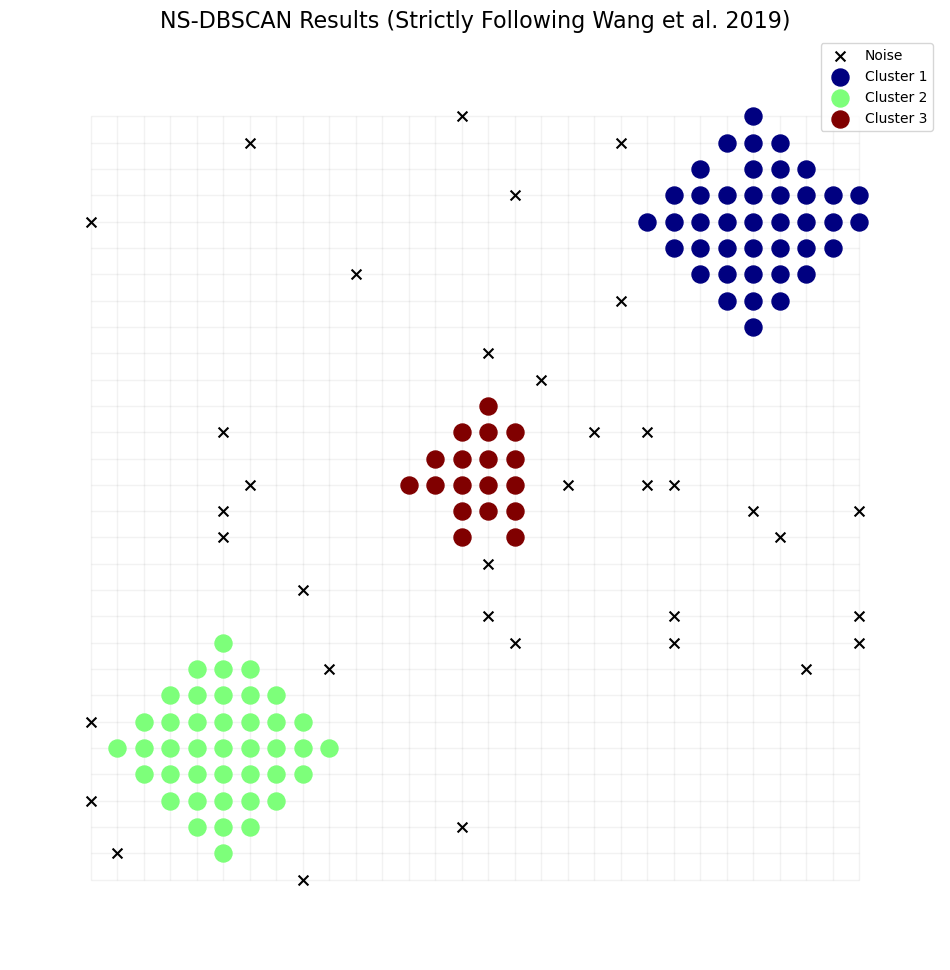

In [3]:
# Cấu hình tham số
EPS = 1.5
MIN_PTS = 4

# Chạy
labels_paper = run_ns_dbscan_paper_version(G, data_nodes, EPS, MIN_PTS)

# Thống kê
n_noise = list(labels_paper.values()).count(-1)
n_clustered = len(labels_paper) - n_noise
print(f"\nKẾT QUẢ:")
print(f"- Tổng số điểm: {n_samples}")
print(f"- Điểm thuộc cụm: {n_clustered}")
print(f"- Điểm nhiễu (NOISE): {n_noise}")

# Vẽ
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

clusters = {}
noise_nodes = []

for p, label in labels_paper.items():
    if label == -1:
        noise_nodes.append(p)
    else:
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(p)

if noise_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=noise_nodes, 
                           node_color='black', node_size=50, node_shape='x', label='Noise')

unique_cluster_ids = list(clusters.keys())
colors = plt.cm.jet(np.linspace(0, 1, len(unique_cluster_ids)))
for i, c_id in enumerate(unique_cluster_ids):
    nx.draw_networkx_nodes(G, pos, nodelist=clusters[c_id], 
                           node_color=[colors[i]], node_size=150, node_shape='o', label=f'Cluster {c_id}')

plt.title("NS-DBSCAN Results (Strictly Following Wang et al. 2019)", fontsize=16)
plt.legend()
plt.axis('off')
plt.show()